# 1. Input Data and Library


In [2]:
import numpy as np 
import pandas as pd
import warnings
warnings.filterwarnings('ignore') # to suppress some matplotlib deprecation warnings
import ast
import math
import matplotlib.pyplot as plt
import matplotlib.style as style
import cv2
import math

from glob import glob
import re
from PIL import Image, ImageDraw 
from tqdm import tqdm
from dask import bag
import gc

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import tensorflow as tf
import keras
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Input, Dropout
from keras.models import Model, Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import backend as K
from keras import Model
from keras.utils import to_categorical

import keras
from keras.layers import *
from keras.callbacks import *
from keras.models import *
from keras.losses import *
from keras.optimizers import *

#from keras.metrics import top_k_categorical_accuracy
#K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
import os
os.listdir("/content/drive/My Drive/Colab Notebooks/AI_Final_Project_input/input")

['train',
 'demo.csv',
 '_DS_Store',
 'test_ans.csv',
 'test.csv',
 'valid.csv',
 'train2']

In [0]:
class_paths = glob('/content/drive/My Drive/Colab Notebooks/AI_Final_Project_input/input/train/*.csv')

# 2. Data Exploration
Some "words" are actually more than one word!  It used spaces to delimit multi-word labels. We need to adjust your label predictions to replace spaces with underscores. 

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# 3. Data Preprocess
We're going to grab the some images from the demo.csv file. Since the word values are read as a string, we need to convert them to a list using the ast.literal_eval function.

In [7]:
strlen = len("/content/drive/My Drive/Colab Notebooks/AI_Final_Project_input/input/train/")
class_paths = glob('/content/drive/My Drive/Colab Notebooks/AI_Final_Project_input/input/train/*.csv')
numstonames = {i: v[strlen:-4].replace(" ", "_") for i, v in enumerate(class_paths)}
print(numstonames)

{0: 'banana', 1: 'bandage', 2: 'bear', 3: 'bed', 4: 'bee', 5: 'belt', 6: 'cactus', 7: 'cake', 8: 'coffee_cup', 9: 'door', 10: 'fork', 11: 'giraffe', 12: 'hand', 13: 'key', 14: 'laptop', 15: 'light_bulb', 16: 'marker', 17: 'paintbrush', 18: 'popsicle', 19: 'raccoon', 20: 'rain', 21: 'roller_coaster', 22: 'snail', 23: 'spoon', 24: 'swan', 25: 'The_Great_Wall_of_China', 26: 'toaster', 27: 'train', 28: 'whale', 29: 'wine_bottle'}


In [8]:
namestonums = {v:k for k,v in numstonames.items()}
namestonums

{'The_Great_Wall_of_China': 25,
 'banana': 0,
 'bandage': 1,
 'bear': 2,
 'bed': 3,
 'bee': 4,
 'belt': 5,
 'cactus': 6,
 'cake': 7,
 'coffee_cup': 8,
 'door': 9,
 'fork': 10,
 'giraffe': 11,
 'hand': 12,
 'key': 13,
 'laptop': 14,
 'light_bulb': 15,
 'marker': 16,
 'paintbrush': 17,
 'popsicle': 18,
 'raccoon': 19,
 'rain': 20,
 'roller_coaster': 21,
 'snail': 22,
 'spoon': 23,
 'swan': 24,
 'toaster': 26,
 'train': 27,
 'whale': 28,
 'wine_bottle': 29}

In [0]:
num_classes = 30
imheight, imwidth = 64, 64  
ims_per_class = 2000

In [0]:
def draw_it(strokes):
    image = Image.new("P", (255,255), color=255)
    image_draw = ImageDraw.Draw(image)
    for stroke in ast.literal_eval(strokes):
        for i in range(len(stroke[0])-1):
            image_draw.line([stroke[0][i], 
                             stroke[1][i],
                             stroke[0][i+1], 
                             stroke[1][i+1]],
                            fill=0, width=5)
    image = image.resize((imheight, imwidth))
    return np.array(image)/255.

In [11]:
train_grand = []

for i,c in enumerate(tqdm(class_paths[0: num_classes])):
    train = pd.read_csv(c, nrows=ims_per_class)
    imagebag = bag.from_sequence(train.drawing.values).map(draw_it) 
    trainarray = np.array(imagebag.compute())
    trainarray = np.reshape(trainarray, (ims_per_class, -1))    
    labelarray = np.full((train.shape[0], 1), i)
    trainarray = np.concatenate((labelarray, trainarray), axis=1)
    train_grand.append(trainarray)
    
#less memory than np.concatenate
train_grand = np.array([train_grand.pop() for i in np.arange(num_classes)]) 
train_grand = train_grand.reshape((-1, (imheight*imwidth+1)))

del trainarray
del train

100%|██████████| 30/30 [00:55<00:00,  1.74s/it]


In [12]:
train_grand.shape

(60000, 4097)

In [13]:
train_grand

array([[29.,  1.,  1., ...,  1.,  1.,  1.],
       [29.,  1.,  1., ...,  1.,  1.,  1.],
       [29.,  1.,  1., ...,  1.,  1.,  1.],
       ...,
       [ 0.,  1.,  1., ...,  1.,  1.,  1.],
       [ 0.,  1.,  1., ...,  1.,  1.,  1.],
       [ 0.,  1.,  1., ...,  1.,  1.,  1.]])

In [0]:
np.random.shuffle(train_grand)
y_train, X_train = train_grand[:, 0], train_grand[:, 1:]
X_train = X_train.reshape(X_train.shape[0], imheight, imwidth)

In [15]:
y_train

array([17.,  9., 22., ..., 17., 21., 29.])

In [16]:
y_train[0]

17.0

In [17]:
X_train.shape,y_train.shape,

((60000, 64, 64), (60000,))

Text(0.5, 1.0, 'paintbrush')

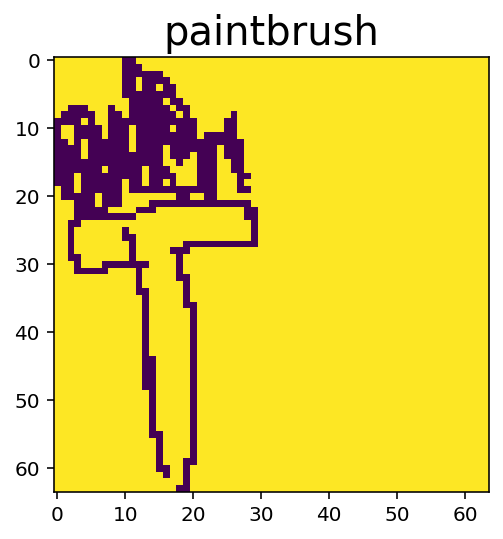

In [18]:
plt.imshow(X_train[1231]); 
plt.title(numstonames[y_train[1231]],fontsize=20)

In [0]:
def random_set(X, y, size=10):
    length = len(X)
    indices = np.random.choice(length, size)
    return X[indices], y[indices]

def random_generated_set(generator, size=10):
    latents = np.random.normal(0, 1, (size, 100))
    return generator.predict_on_batch({'latent_input':latents,
                      'label_input':np.random.randint(30, size=size)})

In [0]:
XX, yy = random_set(X_train,y_train)

In [21]:
type(y_train),type(yy),type(X_train),type(XX)

(numpy.ndarray, numpy.ndarray, numpy.ndarray, numpy.ndarray)

In [22]:
y_train.shape,yy.shape,X_train.shape,XX.shape

((60000,), (10,), (60000, 64, 64), (10, 64, 64))

# 4. Model Training

In [0]:
latent_input = Input(shape=(100,), name='latent_input')
label_input = Input(shape=(1,), name='label_input')
x = Embedding(input_dim=30, output_dim=30)(label_input)
x = Reshape((30,))(x)
x = concatenate([x, latent_input], axis=-1)

In [26]:
latent_input = Input(shape=(100,), name='latent_input')
label_input = Input(shape=(1,), name='label_input')
x = Embedding(input_dim=30, output_dim=30)(label_input)
x = Reshape((30,))(x)
x = concatenate([x, latent_input], axis=-1)
x = Dense(16*16*128)(x)
x = LeakyReLU()(x)
x = Reshape((16,16,128))(x)
x = UpSampling2D()(x)
x = Conv2D(64, kernel_size=3, strides=1, padding='same')(x)
x = LeakyReLU()(x)
x = BatchNormalization()(x)
x = UpSampling2D()(x)
x = Conv2D(32, kernel_size=3, strides=1, padding='same')(x)
x = LeakyReLU()(x)
x = BatchNormalization()(x)
x = Conv2D(1, kernel_size=3, strides=1, padding='same')(x)
x = Activation('sigmoid')(x)
x = Reshape((64,64,))(x)
generator = Model(inputs=[latent_input, label_input], outputs=x)
generator.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
label_input (InputLayer)        (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 1, 30)        900         label_input[0][0]                
__________________________________________________________________________________________________
reshape_6 (Reshape)             (None, 30)           0           embedding_4[0][0]                
__________________________________________________________________________________________________
latent_input (InputLayer)       (None, 100)          0                                            
____________________________________________________________________________________________

In [28]:
img_input = Input(shape=(64,64,))
x = Reshape((64,64,1))(img_input)
x = Conv2D(16, kernel_size=3, strides=2, padding='same')(x)
x = LeakyReLU()(x)
x = BatchNormalization()(x)
x = Conv2D(32, kernel_size=3, strides=2, padding='same')(x)
x = LeakyReLU()(x)
x = BatchNormalization()(x)
x = Conv2D(64, kernel_size=3, strides=2, padding='same')(x)
x = LeakyReLU()(x)
x = BatchNormalization()(x)
x = Conv2D(128, kernel_size=3, strides=2, padding='same')(x)
x = LeakyReLU()(x)
x = Dropout(0.03)(x)
x = BatchNormalization()(x)
x = Flatten()(x)
x = Dense(30, activation='softmax')(x)
discriminator = Model(inputs=img_input, outputs=x)
discriminator.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 64, 64)            0         
_________________________________________________________________
reshape_10 (Reshape)         (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 32, 32, 16)        160       
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 32, 32, 16)        0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 32, 32, 16)        64        
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 16, 16, 32)        4640      
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 16, 16, 32)        0   

In [29]:
latent_input = Input(shape=(100,), name='latent_input')
label_input = Input(shape=(1,), name='label_input')
x = generator([latent_input, label_input])
x = discriminator(x)
gan = Model(inputs=[latent_input, label_input], outputs=x)
discriminator.trainable = False
gan.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
latent_input (InputLayer)       (None, 100)          0                                            
__________________________________________________________________________________________________
label_input (InputLayer)        (None, 1)            0                                            
__________________________________________________________________________________________________
model_2 (Model)                 (None, 64, 64)       4386437     latent_input[0][0]               
                                                                 label_input[0][0]                
__________________________________________________________________________________________________
model_4 (Model)                 (None, 30)           159582      model_2[1][0]              

In [0]:
discriminator.trainable = True
discriminator.compile(loss='sparse_categorical_crossentropy', metrics=['acc'], optimizer=Adam(0.001))
discriminator.trainable = False
gan.compile(loss='sparse_categorical_crossentropy', metrics=['acc'], optimizer=Adam(0.0003))

In [57]:
save_interval = 300
epochs = save_interval*20+1
batch_size=60
history = {'dloss':[], 'gloss':[]}
for iteration in range(epochs):
    discriminator.trainable=True
    X_sample, y_sample = random_set(X_train, y_train, batch_size)
    dloss_real = discriminator.train_on_batch(X_sample, y_sample)
    dloss_fake = discriminator.train_on_batch(random_generated_set(generator, size=batch_size), np.full(batch_size, 10))
    
    discriminator.trainable=False
    
    gan_labels = np.random.randint(30, size=batch_size)
    gloss = gan.train_on_batch({'latent_input':np.random.normal(0, 1, (batch_size, 100)),'label_input':gan_labels}, gan_labels)
    
    history['dloss'].append((dloss_real[0]+dloss_fake[0])/2)
    history['gloss'].append(gloss[0])
    if iteration % save_interval == 0:
        print('Epochs={}'.format(iteration))
        print('generator: loss={}. acc={}'.format(gloss[0], gloss[1]))
        print('discriminator: loss_real={}, acc_real={}'.format(dloss_real[0],dloss_real[1]))
        print('    loss_fake={}, acc_fake={}'.format(dloss_fake[0],dloss_fake[1]))
        #generator.save_weights('/content/drive/My Drive/Colab Notebooks/AI_Final_Project_input/output/generator_{0:05d}.h5'.format(iteration))
        generator.save_weights('generator_{0:05d}.h5'.format(iteration))

Epochs=0
generator: loss=5.682885646820068. acc=0.03333333507180214
discriminator: loss_real=0.9736126065254211, acc_real=0.75
    loss_fake=0.03558245673775673, acc_fake=0.9833333492279053
Epochs=300
generator: loss=5.538022994995117. acc=0.01666666753590107
discriminator: loss_real=0.2917117476463318, acc_real=0.9166666865348816
    loss_fake=0.01914871484041214, acc_fake=1.0
Epochs=600
generator: loss=5.211973667144775. acc=0.05000000074505806
discriminator: loss_real=0.7868928909301758, acc_real=0.7666666507720947
    loss_fake=0.0285594891756773, acc_fake=1.0
Epochs=900
generator: loss=5.451120853424072. acc=0.0833333358168602
discriminator: loss_real=0.7510415315628052, acc_real=0.800000011920929
    loss_fake=0.03126468136906624, acc_fake=1.0
Epochs=1200
generator: loss=6.782569408416748. acc=0.01666666753590107
discriminator: loss_real=0.8446324467658997, acc_real=0.7166666388511658
    loss_fake=0.0077324965968728065, acc_fake=1.0
Epochs=1500
generator: loss=7.24146032333374. 

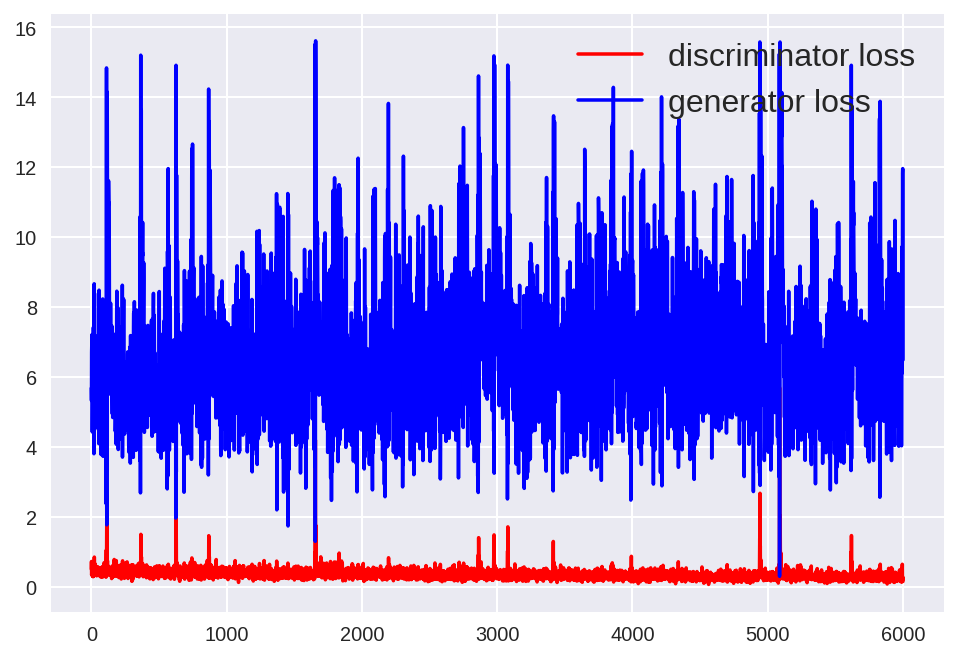

In [58]:
plt.style.use('seaborn')
plt.plot(history['dloss'], 'r')
plt.plot(history['gloss'], 'b')
plt.legend(['discriminator loss', 'generator loss'], loc='upper right',fontsize=16)

In [0]:
import glob
checkpoints = sorted(glob.glob('generator_*.h5'))

In [60]:
checkpoints

['generator_00000.h5',
 'generator_00300.h5',
 'generator_00600.h5',
 'generator_00900.h5',
 'generator_01200.h5',
 'generator_01500.h5',
 'generator_01800.h5',
 'generator_02100.h5',
 'generator_02400.h5',
 'generator_02700.h5',
 'generator_03000.h5',
 'generator_03300.h5',
 'generator_03600.h5',
 'generator_03900.h5',
 'generator_04200.h5',
 'generator_04500.h5',
 'generator_04800.h5',
 'generator_05100.h5',
 'generator_05400.h5',
 'generator_05700.h5',
 'generator_06000.h5']

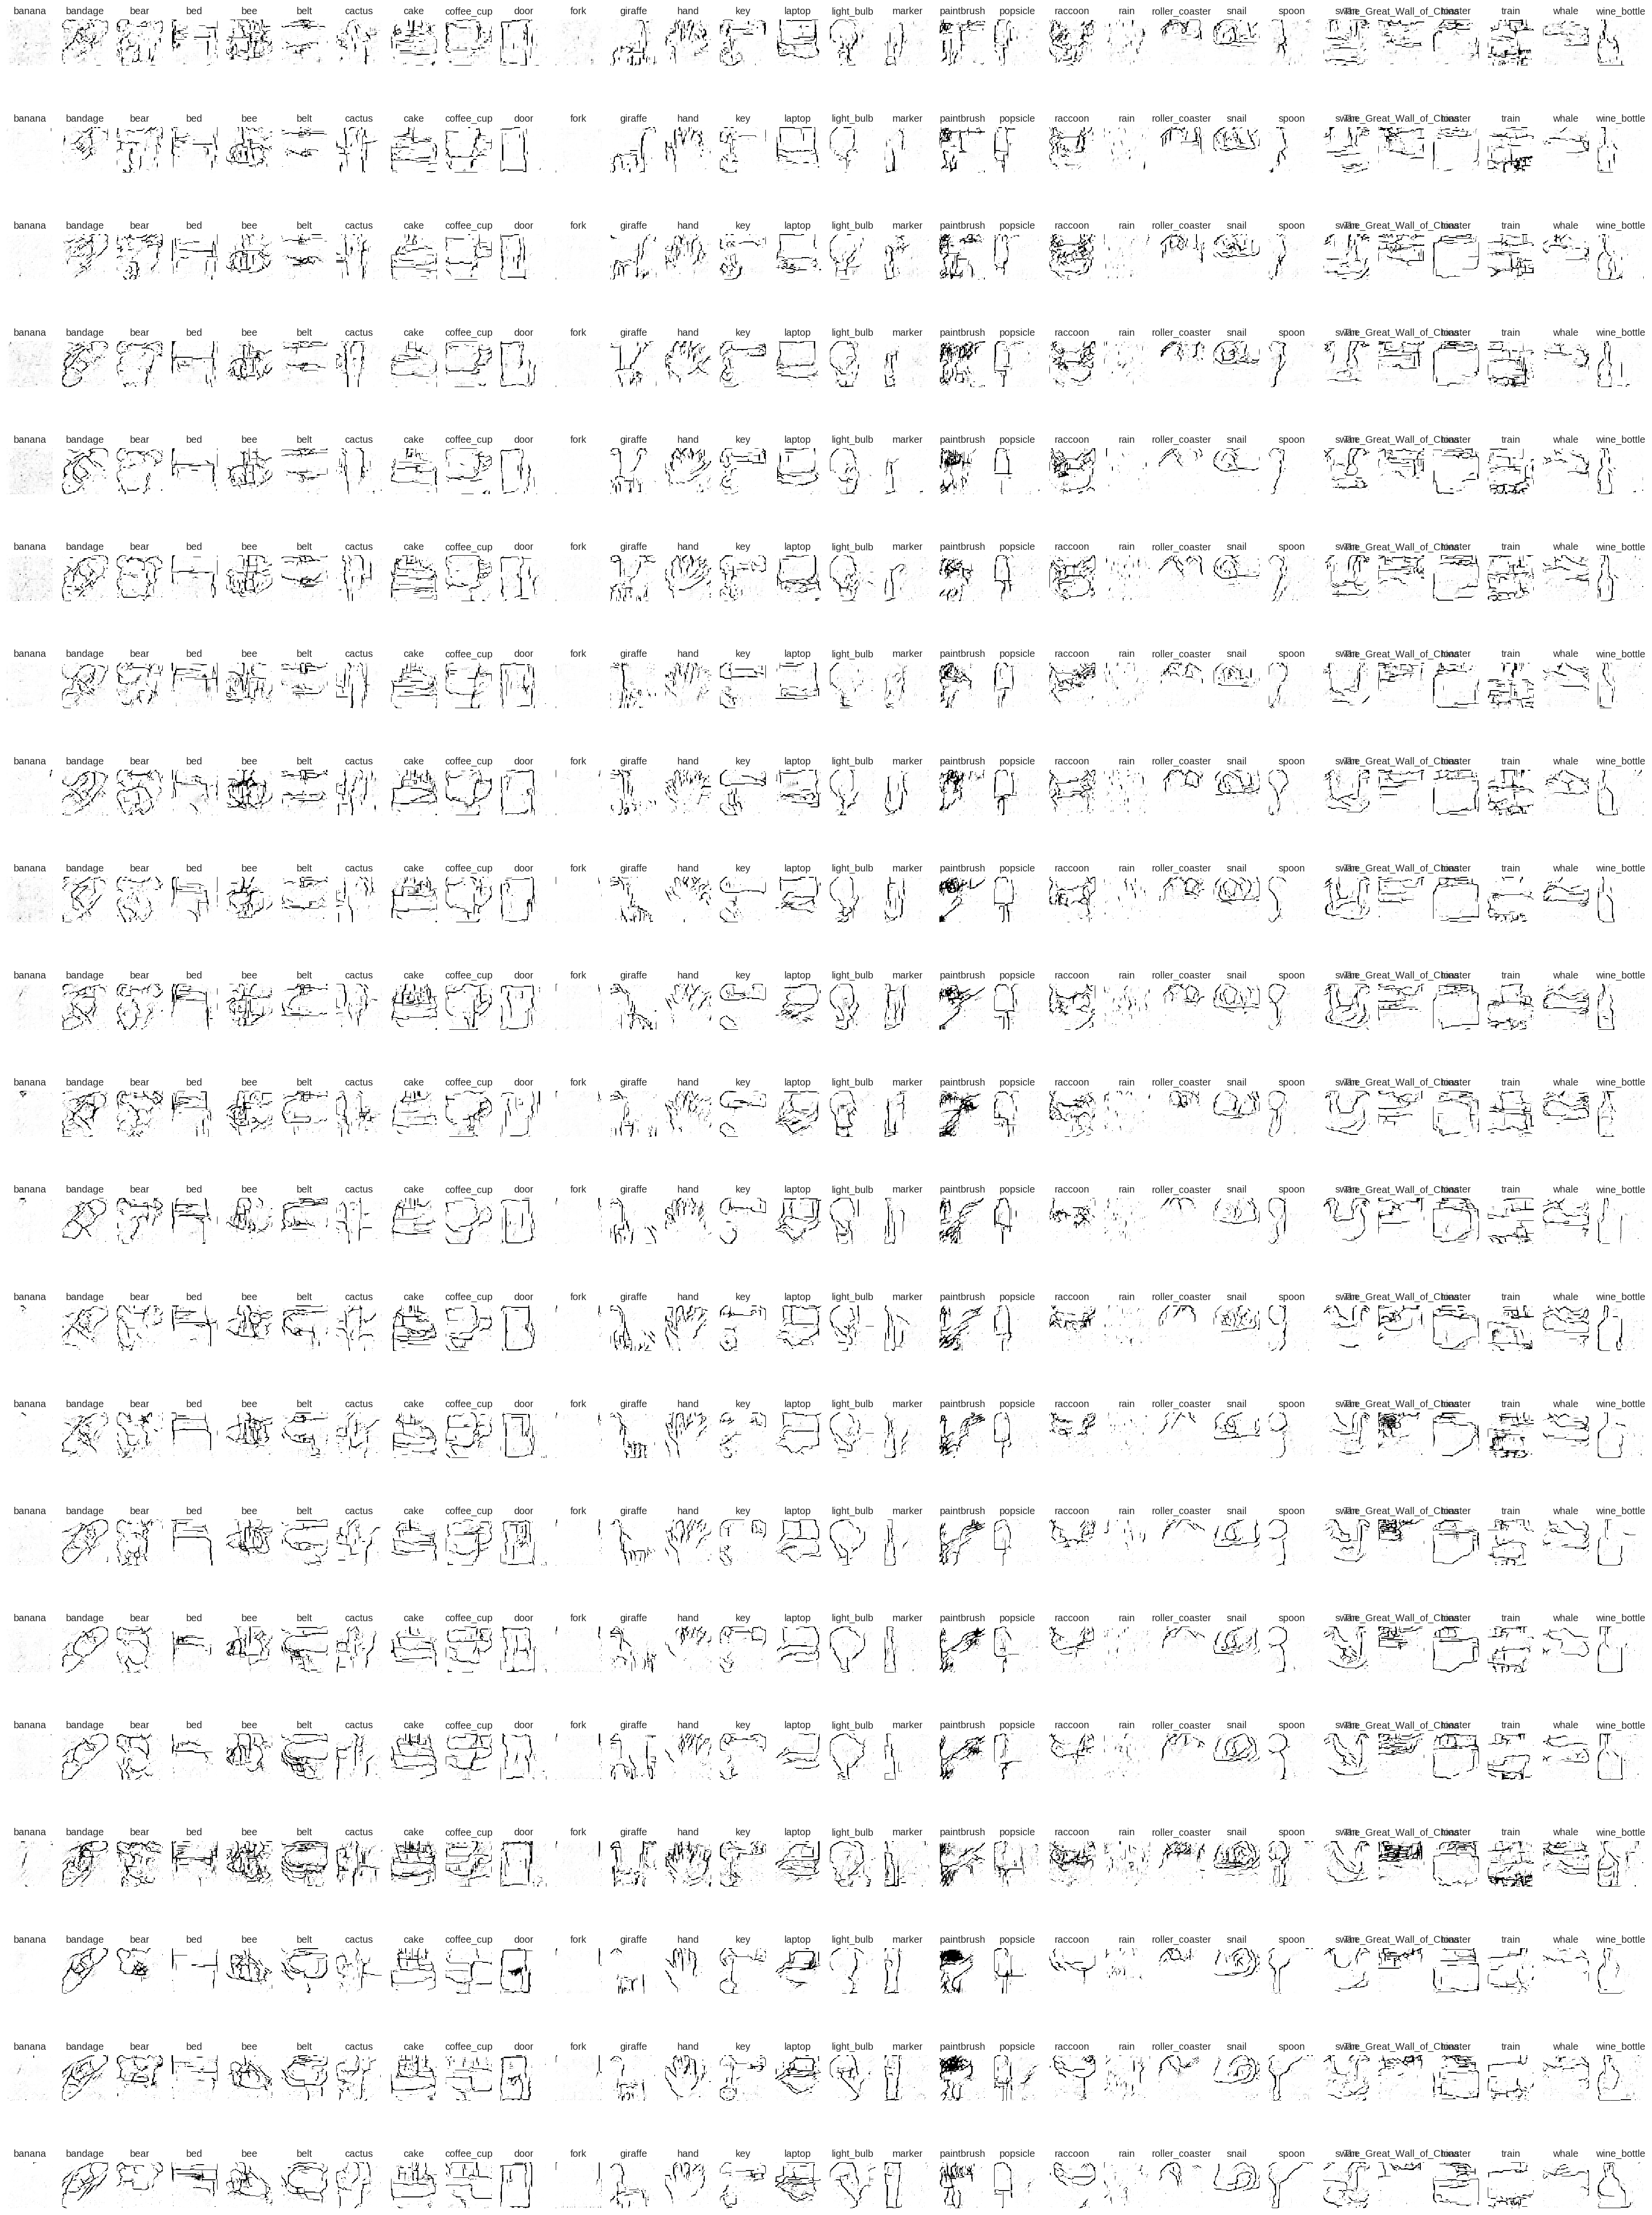

In [61]:
plt.figure(figsize=(30,2*len(checkpoints)))
for i,cp in enumerate(checkpoints):
    generator.load_weights(cp)
    generated = generator.predict_on_batch({'latent_input':np.random.normal(0, 1, (30, 100)),'label_input':np.arange(30)})
    for j, g in enumerate(generated):
        plt.subplot(len(checkpoints),30,30*i+j+1)
        plt.imshow(g, cmap='gray')
        plt.title(numstonames[j],fontsize=10)
        plt.axis('off')

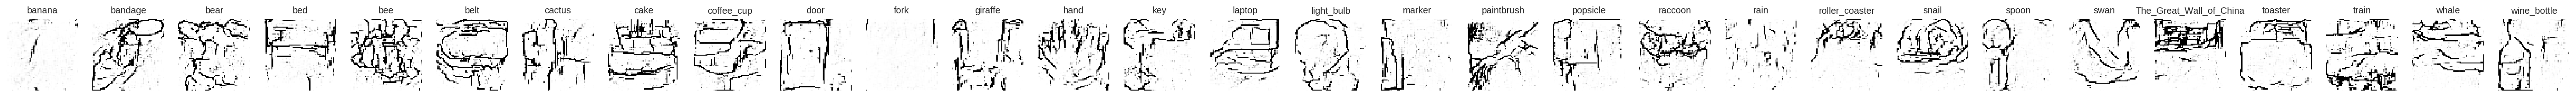

In [62]:
generator.load_weights('generator_05100.h5')
generated = generator.predict_on_batch({'latent_input':np.random.normal(0, 1, (30, 100)),'label_input':np.arange(30)})
plt.figure(figsize=(50,50))
for j, g in enumerate(generated):
  plt.subplot(1,30,j+1)
  plt.imshow(g, cmap='gray')
  plt.title(numstonames[j],fontsize=10)
  plt.axis('off')

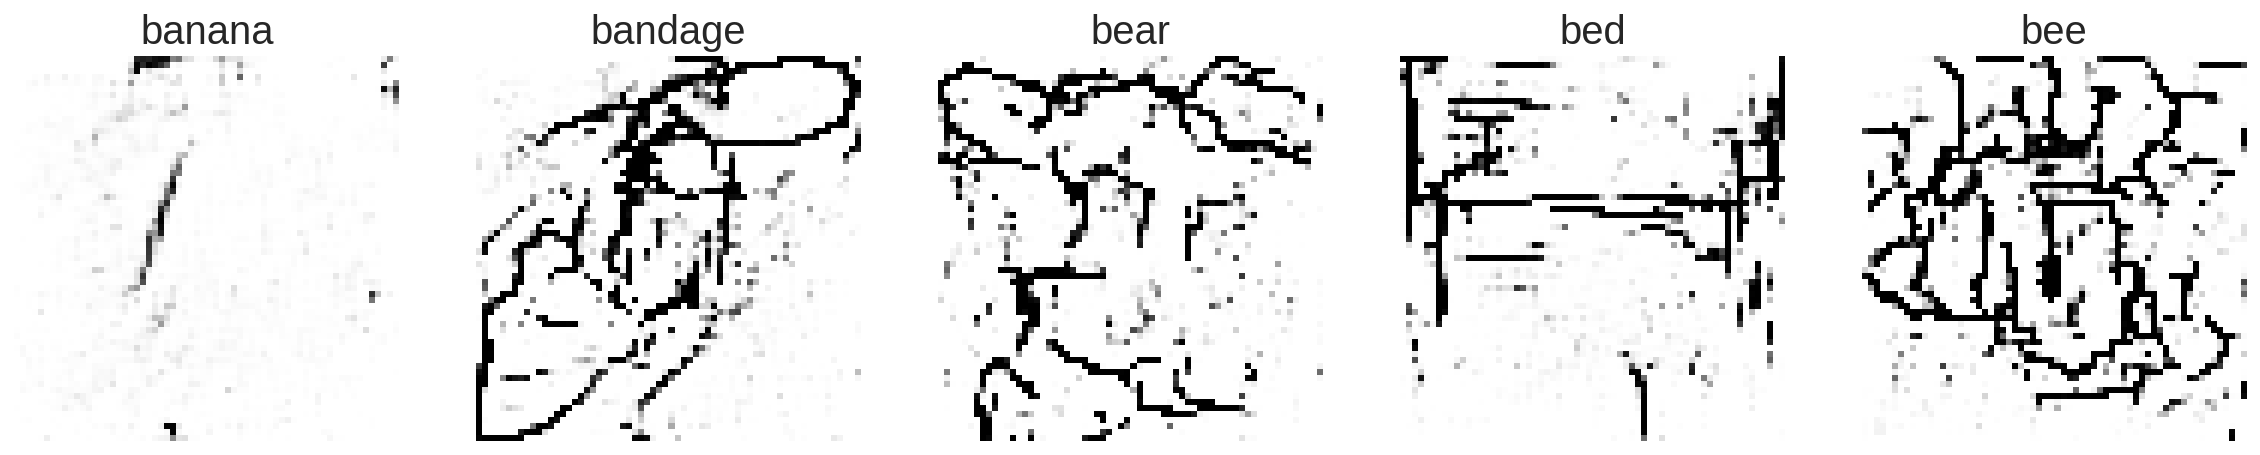

In [63]:
generator.load_weights('generator_05100.h5')
generated = generator.predict_on_batch({'latent_input':np.random.normal(0, 1, (30, 100)),'label_input':np.arange(30)})
plt.figure(figsize=(20,20))
for i in range(5):
  plt.subplot(1,5,i+1)
  plt.imshow(generated[i], cmap='gray')
  plt.title(numstonames[i],fontsize=20)
  plt.axis('off')

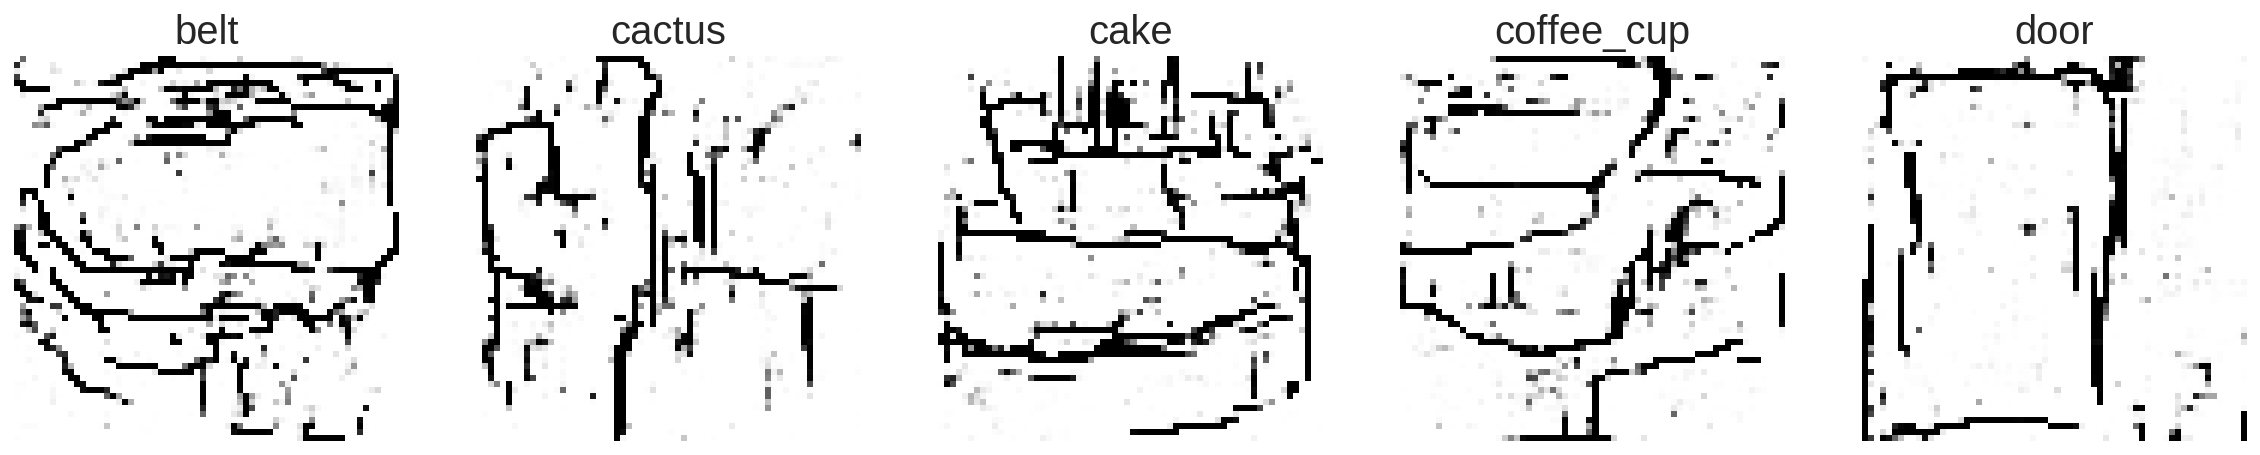

In [64]:
plt.figure(figsize=(20,20))
for i in range(5):
  plt.subplot(1,5,i+1)
  plt.imshow(generated[i+5], cmap='gray')
  plt.title(numstonames[i+5],fontsize=20)
  plt.axis('off')

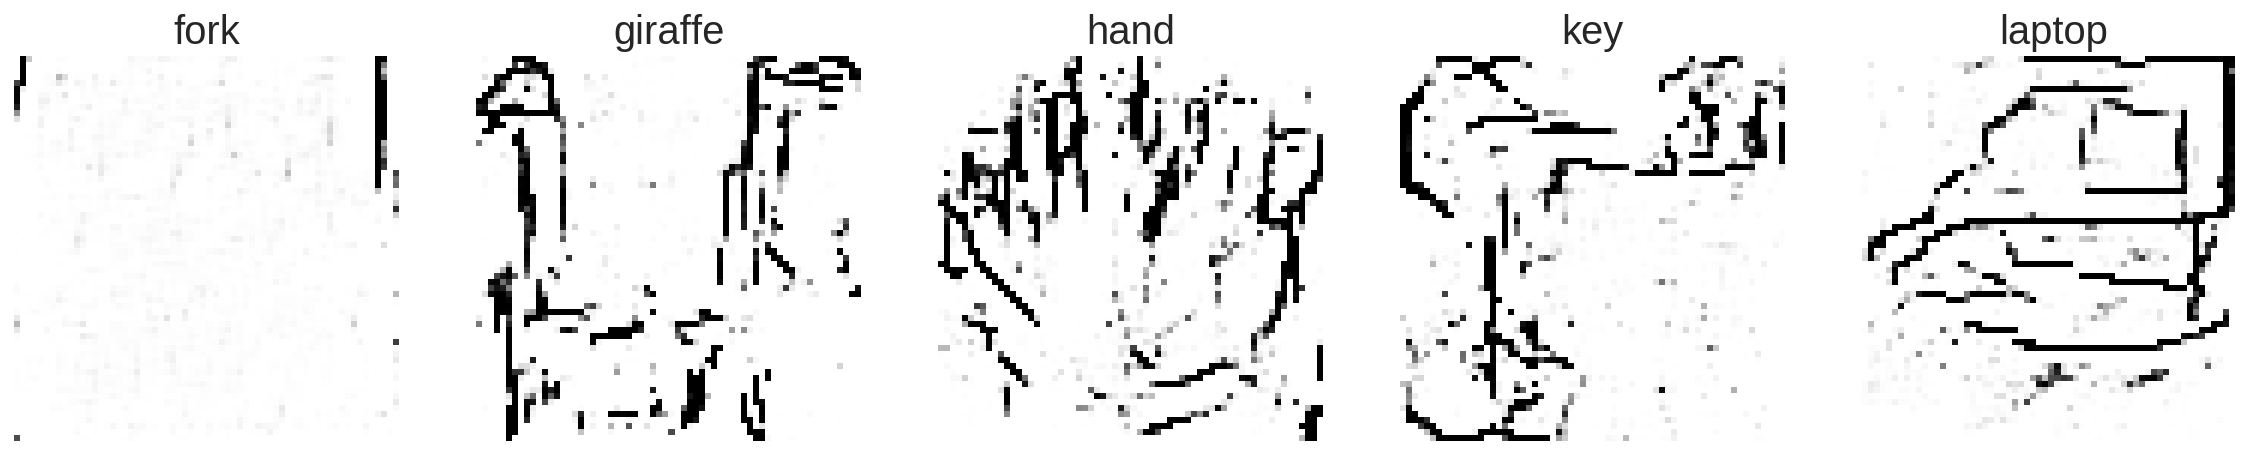

In [65]:
plt.figure(figsize=(20,20))
for i in range(5):
  plt.subplot(1,5,i+1)
  plt.imshow(generated[i+10], cmap='gray')
  plt.title(numstonames[i+10],fontsize=20)
  plt.axis('off')

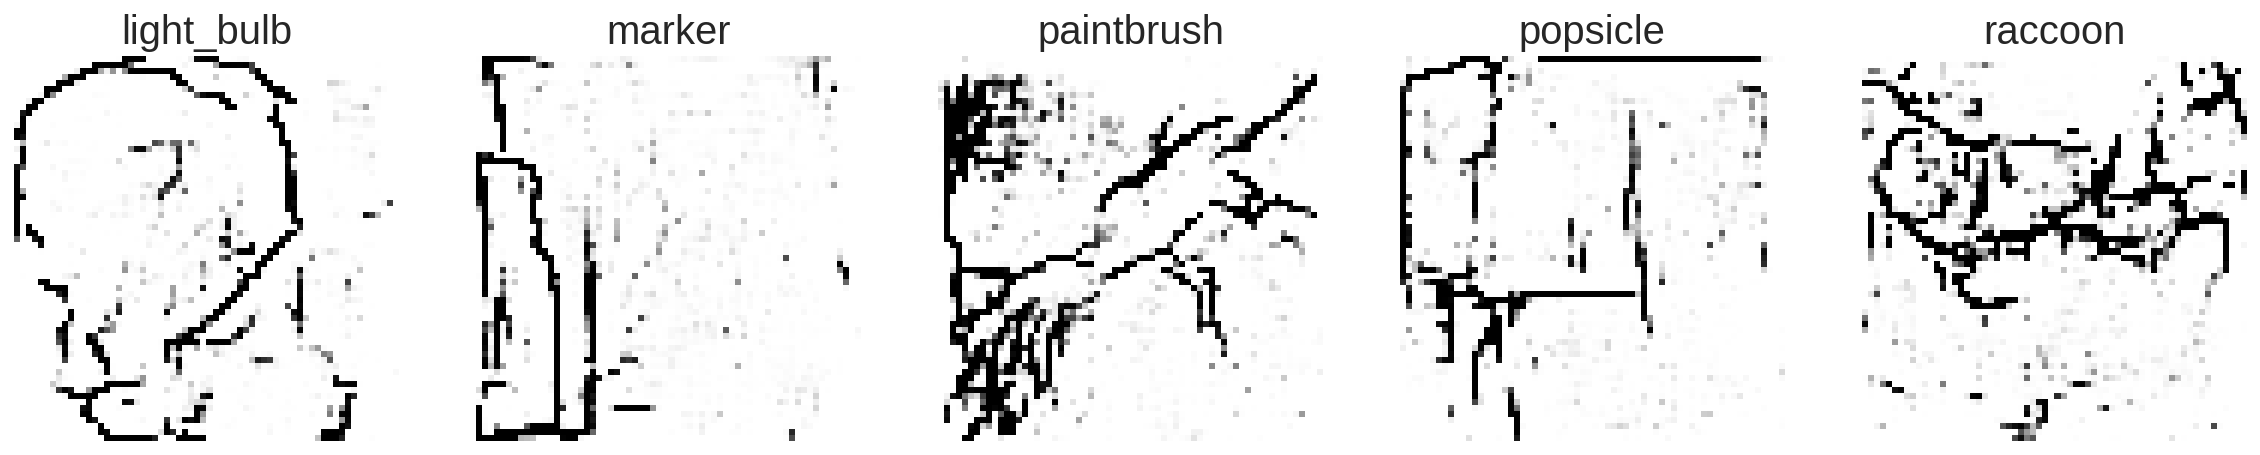

In [66]:
plt.figure(figsize=(20,20))
for i in range(5):
  plt.subplot(1,5,i+1)
  plt.imshow(generated[i+15], cmap='gray')
  plt.title(numstonames[i+15],fontsize=20)
  plt.axis('off')

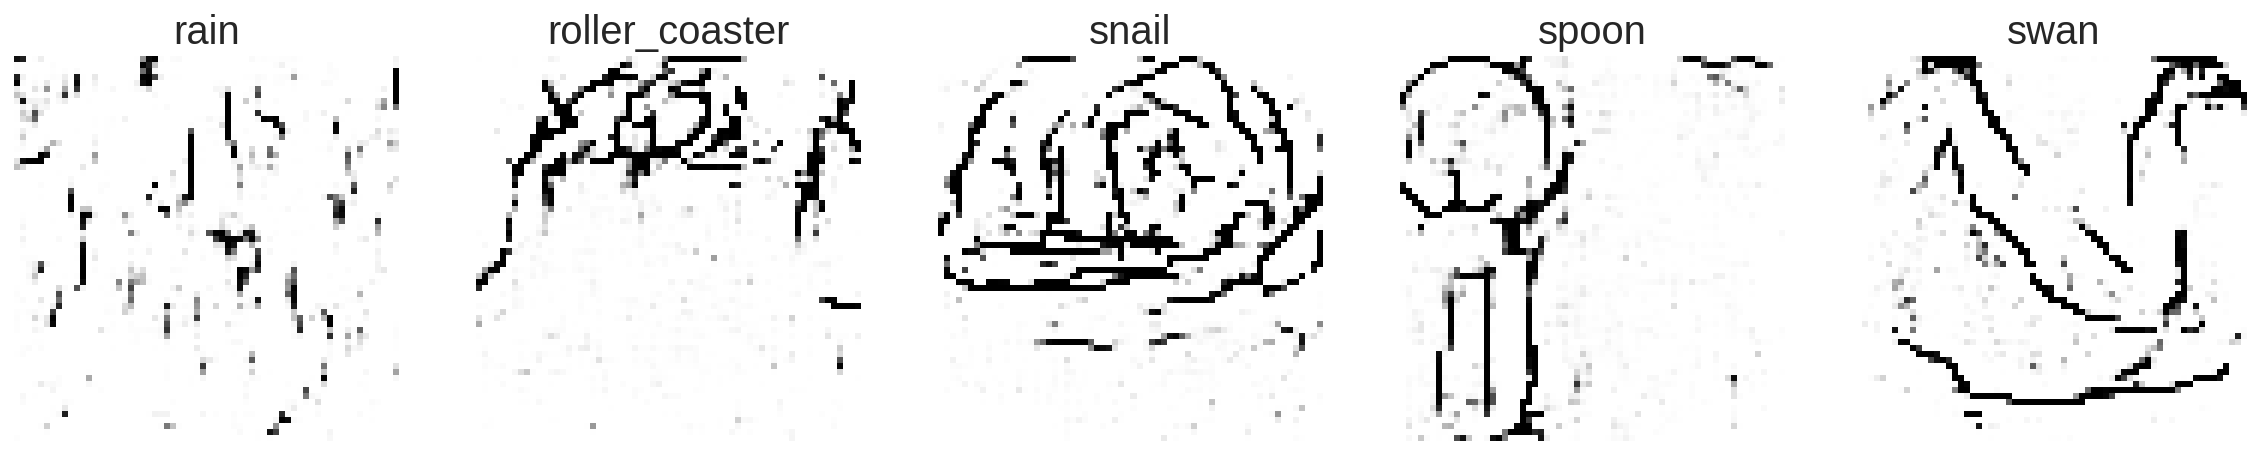

In [67]:
plt.figure(figsize=(20,20))
for i in range(5):
  plt.subplot(1,5,i+1)
  plt.imshow(generated[i+20], cmap='gray')
  plt.title(numstonames[i+20],fontsize=20)
  plt.axis('off')

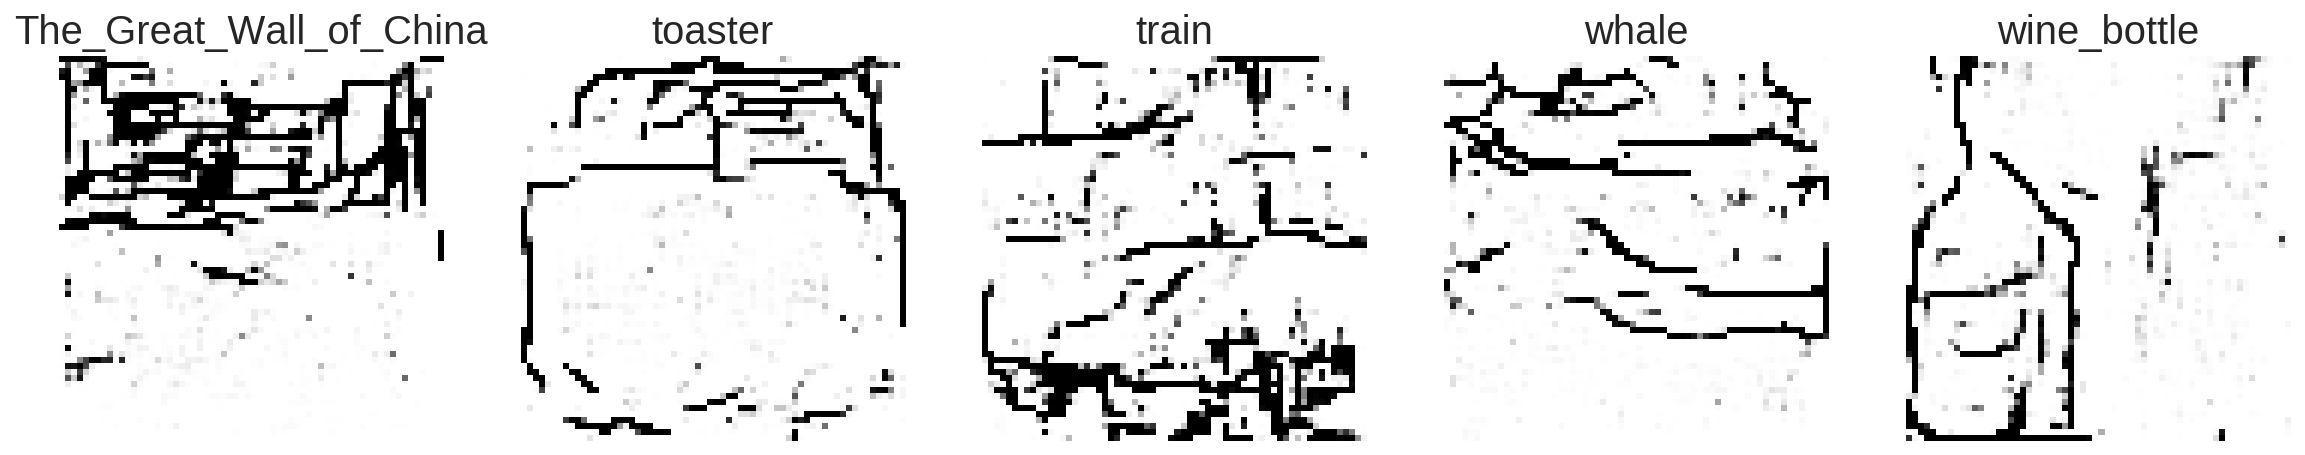

In [68]:
plt.figure(figsize=(20,20))
for i in range(5):
  plt.subplot(1,5,i+1)
  plt.imshow(generated[i+25], cmap='gray')
  plt.title(numstonames[i+25],fontsize=20)
  plt.axis('off')

In [69]:
print(numstonames)

{0: 'banana', 1: 'bandage', 2: 'bear', 3: 'bed', 4: 'bee', 5: 'belt', 6: 'cactus', 7: 'cake', 8: 'coffee_cup', 9: 'door', 10: 'fork', 11: 'giraffe', 12: 'hand', 13: 'key', 14: 'laptop', 15: 'light_bulb', 16: 'marker', 17: 'paintbrush', 18: 'popsicle', 19: 'raccoon', 20: 'rain', 21: 'roller_coaster', 22: 'snail', 23: 'spoon', 24: 'swan', 25: 'The_Great_Wall_of_China', 26: 'toaster', 27: 'train', 28: 'whale', 29: 'wine_bottle'}


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


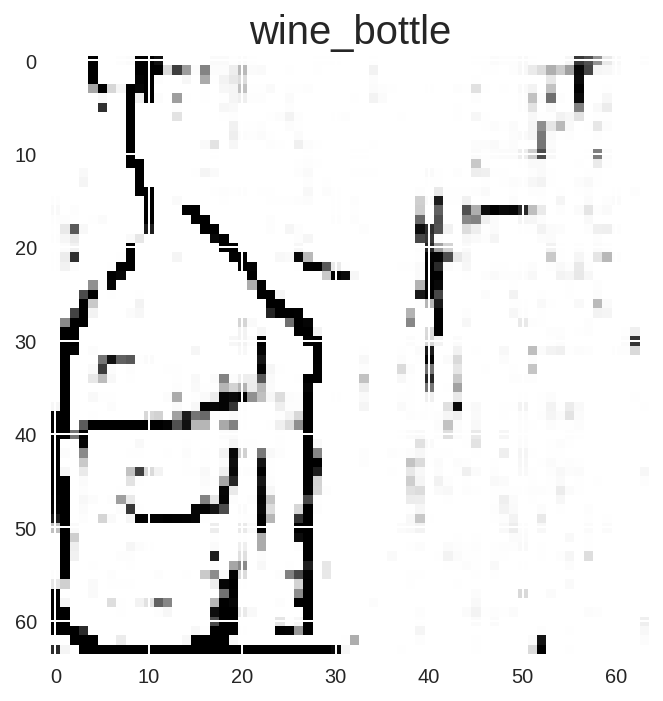

In [70]:
from google.colab import drive
drive.mount('/content/drive')

for i in range(30):
  plt.imshow(generated[i], cmap='gray')
  plt.title(numstonames[i],fontsize=20)
  plt.savefig('/content/drive/My Drive/Colab Notebooks/AI_Final_Project_input/output/{}.png'.format(numstonames[i]))